In [29]:
import torch, torchvision
import detectron2
import os

from detectron2.utils.logger import setup_logger

import numpy as np
import cv2
import random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

In [7]:
import matplotlib.pyplot as plt

In [8]:
name = 'full-aug'

In [9]:
def cv2_imshow(im):
    cv2.imshow('fiile', im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/train.json", 
                        "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/images")
register_coco_instances("val", {}, "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/val.json", 
                        "/home/golden/kenya_drones/night_baboons/annotations/original-annotations/images")

In [11]:
train_metadata = MetadataCatalog.get("train")

In [12]:
MetadataCatalog.get("val").evaluator_type

'coco'

In [13]:
train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")

In [14]:
# for d in val_dicts:
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     cv2_imshow(vis.get_image()[:, :, ::-1])

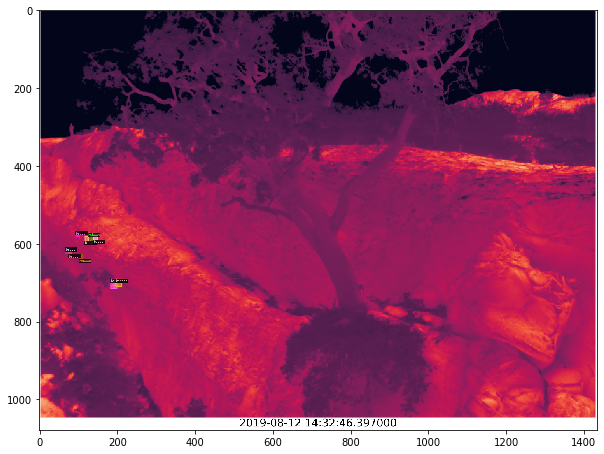

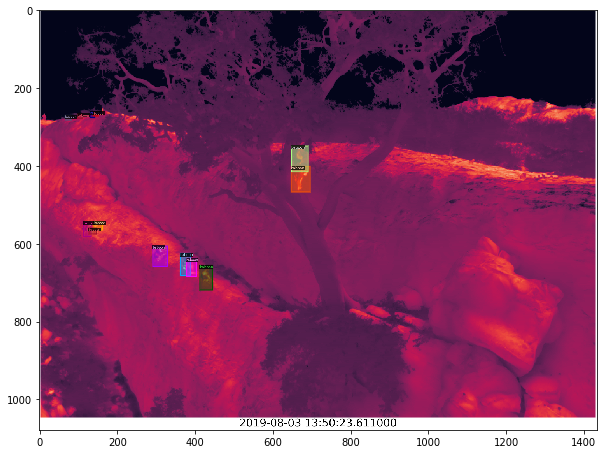

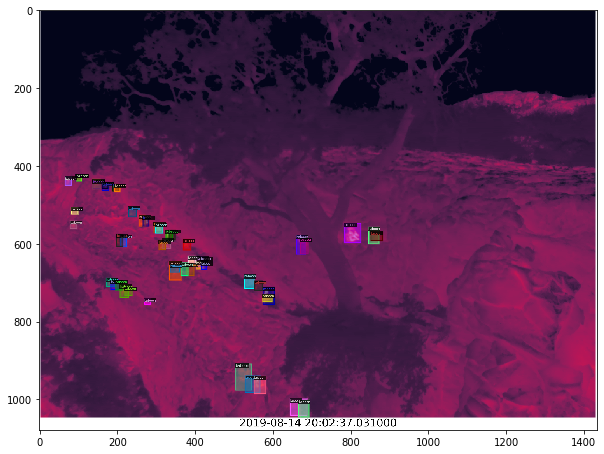

In [18]:
for d in random.sample(train_dicts, 3):
# for d in train_dicts:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10,10))
    plt.imshow(vis.get_image())

['faster_rcnn_R_101_C4_3x.yaml',
 'faster_rcnn_R_101_DC5_3x.yaml',
 'faster_rcnn_R_101_FPN_3x.yaml',
 'faster_rcnn_R_50_C4_1x.yaml',
 'faster_rcnn_R_50_C4_3x.yaml',
 'faster_rcnn_R_50_DC5_1x.yaml',
 'faster_rcnn_R_50_DC5_3x.yaml',
 'faster_rcnn_R_50_FPN_1x.yaml',
 'faster_rcnn_R_50_FPN_3x.yaml',
 'faster_rcnn_X_101_32x8d_FPN_3x.yaml',
 'fast_rcnn_R_50_FPN_1x.yaml',
 'retinanet_R_101_FPN_3x.yaml',
 'retinanet_R_50_FPN_1x.yaml',
 'retinanet_R_50_FPN_3x.yaml',
 'rpn_R_50_C4_1x.yaml',
 'rpn_R_50_FPN_1x.yaml']

In [28]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
    "/home/golden/detectron2-master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)



cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
cfg.DATALOADER.NUM_WORKERS = 6
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.019
cfg.SOLVER.MAX_ITER = (2000)
cfg.SOLVER.WARMUP_ITERS = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (256)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

cfg.TEST.EVAL_PERIOD = 100
cfg.TEST.DETECTIONS_PER_IMAGE = 200

cfg.INPUT.MIN_SIZE_TRAIN = (0)
cfg.INPUT.MIN_SIZE_TEST = (0)
cfg.INPUT.MAX_SIZE_TRAIN = (2871)
cfg.INPUT.MAX_SIZE_TEST = (2871)

cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.TYPE = "absolute"
cfg.INPUT.CROP.SIZE = (720.0, 1280.0)
cfg.INPUT.VER_FLIP = True
cfg.INPUT.CONTRAST = True
cfg.INPUT.CONTRAST_RANGE = (.5, 1.5)
cfg.INPUT.BRIGHTNESS = True
cfg.INPUT.BRIGHTNESS_RANGE = (.4, 1.3)



cfg.OUTPUT_DIR = os.path.join(cfg.OUTPUT_DIR, '{}_maxiter-{}_lr-{}_detectPerIm-{}_minsize-{}_batchsize-{}'.format(
    name, cfg.SOLVER.MAX_ITER, cfg.SOLVER.BASE_LR, cfg.TEST.DETECTIONS_PER_IMAGE, 
    np.min(cfg.INPUT.MIN_SIZE_TRAIN), cfg.SOLVER.IMS_PER_BATCH))


AssertionError: Config file 'C:/Users/cloftus/detectron2-windows/configs/COCO-Detection/' does not exist!

In [12]:
print(cfg.INPUT)

BRIGHTNESS: True
BRIGHTNESS_RANGE: (0.4, 1.3)
CONTRAST: True
CONTRAST_RANGE: (0.5, 1.5)
CROP:
  ENABLED: True
  SIZE: (720.0, 1280.0)
  TYPE: absolute
FORMAT: BGR
MASK_FORMAT: polygon
MAX_SIZE_TEST: 2871
MAX_SIZE_TRAIN: 2871
MIN_SIZE_TEST: 0
MIN_SIZE_TRAIN: 0
MIN_SIZE_TRAIN_SAMPLING: choice
VER_FLIP: True


In [13]:
# mapper = MyDatasetMapper(cfg)
# loader = build_detection_train_loader(cfg, mapper=mapper)
# loader_iter = iter(loader)

In [14]:
# import matplotlib.pyplot as plt

# for im_num in range(4):

#     batch = next(loader_iter)

#     for im_dict in batch:
#         image = im_dict['image'].numpy()
#         image = np.transpose(image, [1, 2, 0])
#         image /= 255
#         cv2_imshow(image)

In [12]:
from detectron2.data import build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data.dataset_mapper import DatasetMapper
import copy

import logging

import torch

class MyDatasetMapper(DatasetMapper):
    
    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None

        self.tfm_gens = utils.build_transform_gen(cfg, is_train)
        
        if cfg.INPUT.VER_FLIP:
            self.tfm_gens.append(T.RandomFlip(vertical=True, horizontal=False))
        if cfg.INPUT.CONTRAST:
            self.tfm_gens.append(T.RandomContrast(*cfg.INPUT.CONTRAST_RANGE))
        if cfg.INPUT.BRIGHTNESS:
            self.tfm_gens.append(T.RandomBrightness(*cfg.INPUT.BRIGHTNESS_RANGE))
            
        logger = logging.getLogger(__name__)
        logger.info("TransformGens used in training: " + str(self.tfm_gens))

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )

        self.is_train = is_train
    
    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.
        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        utils.check_image_size(dataset_dict, image)

        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(dataset_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(
            image.transpose(2, 0, 1).astype("float32")
        ).contiguous()
        # Can use uint8 if it turns out to be slow some day

        if not self.is_train:
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)
                    
            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )

            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
            dataset_dict["instances"] = utils.filter_empty_instances(instances)

        return dataset_dict


class Trainer(DefaultTrainer):
    """ Implements build_evaluator. 
    Only for coco.
    """
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        if evaluator_type == "coco":
            return COCOEvaluator(dataset_name, cfg, True, output_folder)

        else:
            raise NotImplementedError("Only coco evaluators are currently implemented. Change build_evaluator().")
            
            
    @classmethod
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable
        It now calls :func:`detectron2.data.build_detection_train_loader` but now with mapper.
        Overwrite it if you'd like a different data loader.
        """
        
        mapper = MyDatasetMapper(cfg)
        
        return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/13 18:08:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.


[04/13 18:08:50 d2.engine.train_loop]: Starting training from iteration 0
[04/13 18:09:34 d2.utils.events]: eta: 0:32:26  iter: 19  total_loss: 1.847  loss_cls: 0.711  loss_box_reg: 0.727  loss_rpn_cls: 0.230  loss_rpn_loc: 0.146  time: 1.7674  data_time: 1.3354  lr: 0.003625  max_mem: 8330M
[04/13 18:10:07 d2.utils.events]: eta: 0:32:03  iter: 39  total_loss: 1.730  loss_cls: 0.653  loss_box_reg: 0.786  loss_rpn_cls: 0.096  loss_rpn_loc: 0.158  time: 1.6934  data_time: 0.7134  lr: 0.007422  max_mem: 8330M
[04/13 18:10:39 d2.utils.events]: eta: 0:31:45  iter: 59  total_loss: 1.467  loss_cls: 0.561  loss_box_reg: 0.673  loss_rpn_cls: 0.083  loss_rpn_loc: 0.134  time: 1.6669  data_time: 0.7170  lr: 0.011218  max_mem: 8330M
[04/13 18:11:17 d2.utils.events]: eta: 0:31:32  iter: 79  total_loss: 1.447  loss_cls: 0.559  loss_box_reg: 0.663  loss_rpn_cls: 0.076  loss_rpn_loc: 0.142  time: 1.7261  data_time: 0.9999  lr: 0.015014  max_mem: 8330M
[04/13 18:11:50 d2.data.datasets.coco]: Loaded 37 

In [16]:
# Check training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("train", )
predictor = DefaultPredictor(cfg)

# for d in random.sample(train_dicts, 3):
for d in train_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata,
                   scale=0.8,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

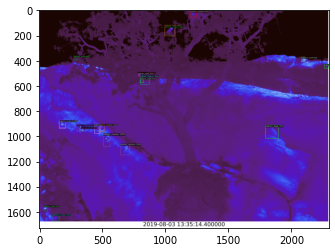

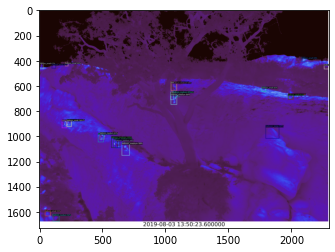

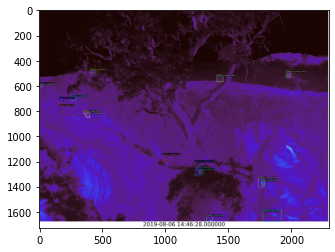

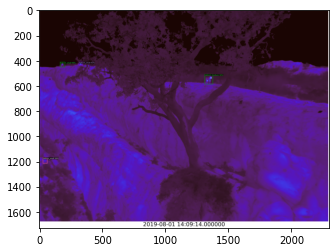

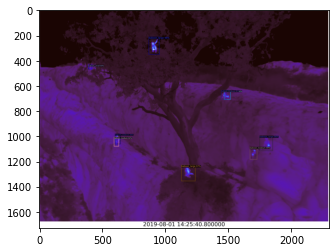

In [14]:
# Check validation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("val", )
predictor = DefaultPredictor(cfg)

for d in val_dicts[:5]:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata,
                   scale=0.8,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image()[:, :, ::-1])


In [11]:
cfg.OUTPUT_DIR

'./output/full-aug_maxiter-2000_lr-0.019_detectPerIm-200_minsize-0_batchsize-8'

In [13]:
print(cfg.MODEL, '\n')

ANCHOR_GENERATOR:
  ANGLES: [[-90, 0, 90]]
  ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
  NAME: DefaultAnchorGenerator
  OFFSET: 0.0
  SIZES: [[32], [64], [128], [256], [512]]
BACKBONE:
  FREEZE_AT: 2
  NAME: build_resnet_fpn_backbone
DEVICE: cuda
FPN:
  FUSE_TYPE: sum
  IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
  NORM: 
  OUT_CHANNELS: 256
KEYPOINT_ON: False
LOAD_PROPOSALS: False
MASK_ON: False
META_ARCHITECTURE: GeneralizedRCNN
PANOPTIC_FPN:
  COMBINE:
    ENABLED: True
    INSTANCES_CONFIDENCE_THRESH: 0.5
    OVERLAP_THRESH: 0.5
    STUFF_AREA_LIMIT: 4096
  INSTANCE_LOSS_WEIGHT: 1.0
PIXEL_MEAN: [103.53, 116.28, 123.675]
PIXEL_STD: [1.0, 1.0, 1.0]
PROPOSAL_GENERATOR:
  MIN_SIZE: 0
  NAME: RPN
RESNETS:
  DEFORM_MODULATED: False
  DEFORM_NUM_GROUPS: 1
  DEFORM_ON_PER_STAGE: [False, False, False, False]
  DEPTH: 50
  NORM: FrozenBN
  NUM_GROUPS: 1
  OUT_FEATURES: ['res2', 'res3', 'res4', 'res5']
  RES2_OUT_CHANNELS: 256
  RES5_DILATION: 1
  STEM_OUT_CHANNELS: 64
  STRIDE_IN_1X1: True
  WIDTH_